In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import copy

action2vect = {0: np.array([0, -1]),
               1: np.array([0, +1]),
               2: np.array([-1, 0]),
               3: np.array([+1, 0])
               }

a2m = {0:'up', 1:'down', 2:'left', 3:'right'}

def random_initialize(Maze, threshold):
    x = np.random.randn(Maze.lx*Maze.ly).reshape(Maze.lx, Maze.ly)
    y = (x < threshold)*(x > -threshold)
    Maze.tile = y
    Maze.load_tile()
    
    floor_labels = np.arange(len(Maze.floors))
    start_floor_label = np.random.choice(floor_labels)
    goal_floor_label = np.random.choice(floor_labels)
    Maze.goal = Maze.floors[goal_floor_label].tolist()
    return Maze
        
class MazeEnv():
    def __init__(self, lx, ly, threshold=0.9, figsize=5, const=0):
        self.lx, self.ly = lx, ly
        
        self = random_initialize(self, threshold)
        self.reset()
        
        self.action_space = [0,1,2,3]
        self.status = 'Initialized'
        self.figsize = figsize

        self.reward_const = const
        self.reward_goal = 1
        self.reward_usual = 0
    def reset(self, coordinate=[None, None]):
        """
        put the agent at certain coordinate randomly.
        """
        floor_labels = np.arange(len(self.floors))
        start_floor_label = np.random.choice(floor_labels)
        self.state = self.floors[start_floor_label]
        self.status = 'Reset'
        self.t = 0
        return self.get_state()
        
    def is_solved(self):
        return self.goal==self.state.tolist()
    
    def get_state(self):
        return copy.deepcopy(self.state)#
            
    def get_next_state(self, state, action):
        add_vector_np = action2vect[action]
        if (state+add_vector_np).tolist() in self.floors.tolist():
            next_state = state+add_vector_np
            self.status = 'Moved'
        else:
            next_state = state
            self.status = 'Move failed'
        self.t += 1
        return next_state
    
    def get_reward(self, state, action, state_p):
        if state_p.tolist()==self.goal:
            reward = self.reward_goal
        elif False:
            reward = 0.1
        else:
            reward = self.reward_usual
        return reward + self.reward_const
    
    def step(self, action):
        state = self.get_state()
        next_state = self.get_next_state(state, action)
        reward = self.get_reward(state, action, next_state)
        self.state = next_state
        return self.get_state(), reward, self.is_solved(), {}
        
    def load_tile(self):
        self.floors = np.array(list(np.where(self.tile==True))).T # (#white tiles, 2), 2 means (x,y) coordinate
        self.holes = np.array(list(np.where(self.tile==True))).T # (#black tiles, 2)
    
    def render_tile(self, ax, cmap='gray'):
        ax.imshow(self.tile.T, interpolation="none", cmap=cmap, vmin=0, vmax=1)
        return ax
    
    def render_arrows(self, ax, values_table):
        lx, ly, _ = values_table.shape
        vmins = np.min(values_table, axis=2).reshape(lx, ly, 1)
        offset = - vmins
        vnoed = values_table*self.tile.reshape(lx, ly, 1) + offset 
        vnoed_maxs = np.max(vnoed, axis=2).reshape(lx, ly, 1)
        vt = np.transpose(vnoed/(vnoed_maxs), (1,0,2))
        width = 0.5
        X, Y= np.meshgrid(np.arange(0, lx, 1), np.arange(0, ly, 1))
        ones = .5*np.ones(lx*ly).reshape(lx, ly)
        zeros= np.zeros(lx*ly).reshape(lx, ly)
        ax.quiver(X, Y, zeros, ones, vt[:,:,0], alpha=0.8, cmap='Reds', scale_units='xy', scale=1) # up
        ax.quiver(X, Y, zeros, -ones, vt[:,:,1], alpha=0.8, cmap='Reds', scale_units='xy', scale=1)# down
        ax.quiver(X, Y, -ones, zeros, vt[:,:,2], alpha=0.8, cmap='Reds', scale_units='xy', scale=1)# left
        ax.quiver(X, Y, ones, zeros, vt[:,:,3], alpha=0.8, cmap='Reds', scale_units='xy', scale=1) # right
        return ax
        
    def render(self, fig=None, ax=None, lines=None, values_table=None, canvas=False):
        if ax is None:
            fig = plt.figure(figsize=(self.figsize, self.figsize))
            ax = fig.add_subplot(111)
            ax.set_xlabel('x'); ax.set_ylabel('y')
        ax = self.render_tile(ax)
        if values_table is not None:
            ax = self.render_arrows(ax, values_table)
        if self.goal is not None:
            ax.scatter(self.goal[0], self.goal[1], marker='d', s=100, color='red', alpha=0.8, label='goal')
        if self.state is not None:
            ax.scatter(self.state[0], self.state[1], marker='o', s=100, color='black', alpha=0.8, label='agent')
        if lines is not None:
            lc = mc.LineCollection(lines, linewidths=2, color='black', alpha=0.5)
            ax.add_collection(lc)   
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', scatterpoints=1)
        if canvas:
            return ax
        else:
            plt.show()
                      
    def play(self, Agent, show=True, fig=None, ax=None, canvas=False):
        lines = []
        while not self.is_solved():
            state0 = self.get_state()
            action = Agent.play()
            self.step(action)
            state1 = self.get_state()
            lines.append([state0, state1])
        if show:
            return self.render(fig=fig, ax=ax, lines=lines, canvas=canvas)

class Agent():
    def __init__(self, policy):
        self.policy = policy
        
    def play(self):
        """
        return a number in [0,1,2,3] corresponding to [up, down, left, right]
        """
        return self.policy.sample()        

class Policy():
    def __init__(self):
        pass
        
class Optimizer():
    def __init__(self):
        pass

## 9-4. 方策勾配法によるRL
バンディット問題でもやりましたが、価値の推定を飛ばして直接 $J(\pi)$ を大きくしにかかる手法を紹介します。つまり、方策を θ でパラメーター化し

$$
\pi(a|s) = \pi_\theta(a|s)
$$

とし、勾配更新

$$
\theta \leftarrow \theta + \eta \nabla_\theta J(\pi_{\theta})
$$

によって方策を更新してゆくことです。これを**方策勾配法(Policy-gradient method)**といいます。この方法が方策改善をするというのは明らかでしょう。問題はやはり、どうやって勾配を計算するかです。




### 方策勾配定理

まず状態価値観数の方策勾配から求めると

$$
\left. \begin{array}{rl}
\nabla_\theta \underbrace{ v_{\pi_\theta}(s) }_{\langle q_{\pi_\theta} (s, a) \rangle_{a \sim \pi_\theta(\cdot|s)}}
&=
\nabla_\theta 
\sum_{a}
q_{\pi_\theta} (s, a)
\pi_\theta(a|s)
\\
&=
\sum_{a}
\Big(
\underbrace{
\nabla_\theta 
q_{\pi_\theta} (s, a)
}_{(*)}
\cdot
\pi_\theta(a|s)
+
q_{\pi_\theta} (s, a)
\cdot
\underbrace{
\nabla_\theta 
\pi_\theta(a| s)
}_{\big(\nabla_\theta \log \pi_\theta(a | s)\big) \cdot \pi_\theta(a | s)}
\Big)
\\
&=
\sum_{a}
\Big(
(*)
+
q_{\pi_\theta} (s, a)
\nabla_\theta \log \pi_\theta(a | s)
\Big) \cdot
\pi_\theta(a|s)
\\
&=
\big\langle
(*)
+
q_{\pi_\theta} (s, a)
\nabla_\theta \log \pi_\theta(a | s)
\big\rangle_{a \sim \pi_\theta(\cdot|s)}
\end{array} \right.
$$

となって、行動価値関数の方策勾配 (＊) を計算する必要に迫られます。しかしこれはベルマン方程式のため、再帰的に計算できます。以下では、$\gamma=1$としました（ベルマン方程式を使う際、微分で落ちる項は始めから落としておきました）：

$$
\left. \begin{array}{rl}
(*) &= 
\nabla_\theta 
\underbrace{q_{\pi_\theta} (s, a)}_{Bellman}
\\
&=
\nabla_\theta 
\langle
q_{\pi_\theta}(s_{+1}, a_{+1})
\rangle_{s_{+1} \sim P_s(\cdot|s, a),\ a_{+1} \sim \pi_\theta(\cdot | s_{+1})}
\\
&=
\nabla_\theta 
\sum_{s_{+1}, a_{+1}}
q_{\pi_\theta}(s_{+1}, a_{+1})
\pi_\theta(a_{+1} | s_{+1})
P_s(s_{+1}|s, a)
\\
&=
\sum_{s_{+1}, a_{+1}}
\Big(
\underbrace{
\nabla_\theta 
q_{\pi_\theta}(s_{+1}, a_{+1})
}_{(*)}
\cdot
\pi_\theta(a_{+1} | s_{+1})
+
q_{\pi_\theta}(s_{+1}, a_{+1})
\cdot
\underbrace{
\nabla_\theta 
\pi_\theta(a_{+1} | s_{+1})
}_{\big(\nabla_\theta \log \pi_\theta(a_{+1} | s_{+1})\big) \cdot \pi_\theta(a_{+1} | s_{+1})}
\Big)
P_s(s_{+1}|s, a)
\\
&=
\sum_{s_{+1}, a_{+1}}
\Big(
(*)
+
q_{\pi_\theta}(s_{+1}, a_{+1})\nabla_\theta \log \pi_\theta(a_{+1} | s_{+1})
\Big) \cdot
\pi_\theta(a_{+1} | s_{+1})
P_s(s_{+1}|s, a)
\\
&=
\big\langle
(*)
+
q_{\pi_\theta}(s_{+1}, a_{+1})\nabla_\theta \log \pi_\theta(a_{+1} | s_{+1})
\big\rangle_{a_{+1} \sim \pi_\theta(\cdot | s_{+1}),\ s_{+1} \sim P_s(\cdot|s, a)}
\\
&=
\Big\langle
\sum_{t=0}^\infty
q_{\pi_\theta}(s_{t+1}, a_{t+1})\nabla_\theta \log \pi_\theta(a_{t+1} | s_{t+1})
\Big\rangle_{MDP,\ (s_0, a_0)=(s, a)}
\end{array} \right.
$$



となります。(＊)をもとの $v$ の勾配に代入すると $a_t = a$ として

$$
\nabla_\theta v(s) =
\Big\langle
\sum_{t=0}^\infty
q_{\pi_\theta}(s_{t}, a_{t})\nabla_\theta \log \pi_\theta(a_{t} | s_{t})
\Big\rangle_{MDP,\ s_0=s}
$$

更に $J(\pi_\theta)$は、これの初期状態による期待値なので、結局

$$
\nabla_\theta J(\pi_\theta)=
\Big\langle
\sum_{t=0}^\infty
q_{\pi_\theta}(s_{t}, a_{t})\nabla_\theta \log \pi_\theta(a_{t} | s_{t})
\Big\rangle_{MDP}
$$

が得られます。これを**方策勾配定理(Policy-gradient theorem)**と言います。

### REINFORCE
実際には、期待値はサンプル$(r_t, s_t, a_t)$によって近似され

$$
\nabla_\theta J(\pi_\theta)
\approx
\sum_{t=0}^\infty
q_{\pi_\theta}(s_{t}, a_{t})\nabla_\theta \log \pi_\theta(a_{t} | s_{t})
$$

とされますが、ここで結局 $q_{\pi_\theta}(s_{t}, a_{t})$ が必要になってしまいました。この行動価値関数の意味は、収益の期待値だったわけですので、これを更に報酬のサンプルで適当な T (典型的にはサンプルのエピソード長さが使われる)

$$
q_{\pi_\theta}(s_{t}, a_{t})
\approx
\frac{1}{T} \sum_{k=0}^{T-1} r_{t+1+k}
$$

で近似することが考えられます。これを**REINFORCEアルゴリズム**と言います$^※$。すなわち、REINFORCEアルゴリズムとは
1. MDPサンプル$\{(r_t, s_t, a_t)\}_{t=0, 2, \dots, T-1}$を得る
2. $
\theta \leftarrow \theta + \eta g_\theta,\quad \text{where} \
g_\theta = \sum_{t=0}^\infty
\Big(
\frac{1}{T} \sum_{k=0}^{T-1} r_{t+1+k}
\Big)
\nabla_\theta \log \pi_\theta(a_{t} | s_{t})
$

を繰り返して、良い方策$\pi_\theta$を探索する手法のことです。
> **【補足】** MDPサンプルは一回の更新につきなるべく多く取ったほうが方策勾配$g_t$の精度が上がります。その場合はエピソード数$m = 0, 1, \dots, M-1$として$g_\theta = 
\frac{1}{M} \sum_{m=0}^{M-1}
\sum_{t=0}^\infty
\Big(
\frac{1}{T} \sum_{k=0}^{T-1} r_{t+1+k}^{(m)}
\Big)
\nabla_\theta \log \pi_\theta(a_{t}^{(m)} | s_{t}^{(m)})$です。
>
> $^※$ 名前は強化の英訳(Reinforce)から取ったと思いきや、原論文[Ronald J. Williams (Machine Learning volume 8, pages229–256(1992))](https://link.springer.com/article/10.1007/BF00992696)によると **RE**ward **I**ncrement = **N**onnegative **F**actor times **O**ffset **R**einforcement times **C**haracteristic **E**ligibility の略とのことです。この命名には9-1で紹介したベースラインが重要になってきますが、後ほど解説します。






#### Softmax方策による実装

バンディット問題のときと同様、softmax方策を導入してみます。つまりエネルギー関数 $H(s, a)$ を用いて

$$
\pi_H(a|s)=
\frac{\exp\{H(s,a)\}}{\sum_{a'} \exp\{
H(s, a')
\}}
$$

とします。



In [23]:
def softmax(xs):
    sps = xs.shape
    num = np.exp(xs)
    den = np.sum(num, axis=2).reshape(sps[0], sps[1], 1)
    return num/den

class Softmax(Policy):
    def __init__(self, env, temp=1, init=0.01):
        self.H = init*np.random.rand(env.lx*env.ly*4).reshape(env.lx, env.ly, 4)
        self.env = env
        self.temp = temp
        
    def get_prob_table(self):
        #fvalues_table = self.f.values_table
        #self.f.get_values(state)
        prob = softmax(self.H/self.temp)
        return prob
    
    def get_prob(self, state):
        x, y = state
        return self.get_prob_table()[x, y, :]
        
    def sample(self):
        prob = self.get_prob(self.env.state)
        action = np.random.choice(self.env.action_space, p=prob)
               #p=prob のオプションは確率リストprobに従ってaction_spaceからサンプルする
        return action

今回の迷路の環境では、時刻$t$で
* ゴールしていれば$r_t = 1$
* していなければ$r_t=0$

だったので、1エピソードで共通して方策勾配は

$$
g_\theta=
\left\{ \begin{array}{ll}
\frac{1}{T} \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta (a_t|s_t) & (\text{if solved}) \\
0 & (\text{if unsolved}) \\
\end{array} \right.
$$

ということになります。この方策勾配はSoftmax方策だともう少し簡単化出来ます。ゴールした場合の勾配にSoftmaxを$\theta=H(s,a)$として代入してみると、9-1の時と同様の計算で

$$
\left. \begin{array}{ll}
\frac{1}{T}
\sum_{t=0}^{T-1} \nabla_{H(s,a)} \log \pi_H (a_t|s_t) 
&=
\frac{1}{T}
\sum_{t=0}^{T-1} 
\Big(
\delta_{(s,a)=(s_t, a_t)} -
\delta_{s=s_t}
\underbrace{
\frac{
\exp\{
H(s_t, a)
\}
}{
\sum_{a'} \exp\{
H(s_t, a')
\}
}
}_{\pi_H(a|s_t)}
\Big)
\\
&=
\frac{1}{T}\Big(
N_{(s,a)} -
N_s \pi_H(a|s)
\Big)
\end{array} \right.
$$



となるのがわかります。ここで
* $N_{(s,a)}$:エピソード中に状態 s で行動 a を選んだ回数
* $N_s$:エピソード中に状態 s を取った回数

を表すとします。そこで REINFORCE は以下のようになります：

In [29]:
class REINFORCE_optimizer(Optimizer):
    def __init__(self, agent, eta):
        self.Policy = agent.policy
        self.H = agent.policy.H
        self.env = agent.policy.env
        self.eta = eta
        self.N_sa = np.zeros((agent.policy.env.lx, agent.policy.env.ly, 4))
        #Parameters(self.Env, init=0) # N_{(s,a)}を数えるためParametersを利用
        self.N = 0 # 実際にself.fが更新された回数を数える。なくてもよい
            
    def update(self, s, a, r_next, s_next):
        x, y = s
        if self.env.is_solved():
            self.N_sa[x, y, a] +=10 # 最後にボーナス（理論から外れるがこれがないと遅い）
            T = self.env.t + 0.01 # オーバーフロー対策(たまに偶然ゴールに落とされてしまうので。。。)
            N_s = np.sum(self.N_sa, axis=2).reshape(self.env.lx, self.env.ly, 1)
            g = (self.N_sa - N_s*self.Policy.get_prob_table())/T # 方策勾配
            self.H += self.eta*g # 更新
            self.N += 1 # なくてもよい
        else:
            self.N_sa[x, y, a] +=1 # ここは必須、ゴールしてない時はN_{(s,a)}を更新
            
    def reset(self):
        self.N_sa = 0*self.N_sa
        # エピソードごとにN_{(s,a)}をリセットする。これは下の学習ループで唱える

エピソード毎の履歴を使うあたりはモンテカルロ法と同じです。

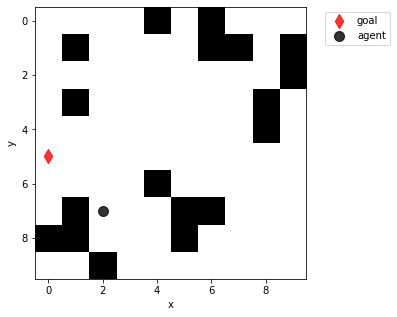

In [12]:
env = MazeEnv(10,10, threshold=1.3, figsize=5)
env.render()

In [81]:
%%time
agent = Agent(policy = Softmax(env, temp=1))
Opt = REINFORCE_optimizer(agent, eta=10)
N_episode = 600 # 600でも十分

for episode in range(N_episode):
    env.reset()
    Opt.reset() # !!! ここ重要　
    while not env.is_solved():
        s = env.get_state()
        a = agent.play()
        s_next, r_next, _, _ = env.step(a)
        if env.status=='Moved':
            Opt.update(s, a, r_next, s_next)
        if env.t > 100: # たまにゴールできない位置に置かれてしまうので
            break

CPU times: user 1.68 s, sys: 28 ms, total: 1.71 s
Wall time: 1.7 s


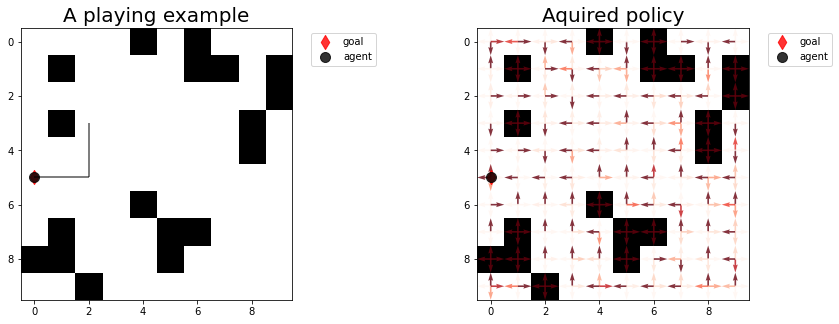

In [82]:
env.reset()

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121); ax1.set_title("A playing example", fontsize=20) 
ax2 = fig.add_subplot(122); ax2.set_title("Aquired policy", fontsize=20) 

env.play(agent, fig=fig, ax=ax1, canvas=True)
env.render(fig=fig, ax=ax2, values_table=agent.policy.H)

#### ベースラインの導入
三度、バンディット問題の方策勾配法を思い出すと、報酬の部分から任意定数を引いても勾配の値は不変なのでした。その性質は今回も同じなのがわかります。つまり

$$
\left. \begin{array}{ll}
\nabla_\theta J(\pi_\theta)&=
\Big\langle
\sum_{t=0}^\infty
q_{\pi_\theta}(s_{t}, a_{t})\nabla_\theta \log \pi_\theta(a_{t} | s_{t})
\Big\rangle_{MDP}
\\
&= \Big\langle
\sum_{t=0}^\infty
\Big(q_{\pi_\theta}(s_{t}, a_{t}) - b(s_t) \Big) \nabla_\theta \log \pi_\theta(a_{t} | s_{t})
\Big\rangle_{MDP}
\end{array} \right.
$$

ここで、バンディット問題とは違うのが状態があることですが、それに従いベースラインも状態依存性を持つことができます。例えば、9-2でコメントしたように、「ゴールするまで負の報酬を与え続ける」等の場合は方策勾配の分散が大きくなると思われるので、ベースラインとして状態価値

$$
b(s) = v_\theta(s)
$$

に取られることが多いようです。

### Actor-Critic
ベースラインを $b(s) = v_\theta(s)$ で導入した後、更にベルマン方程式: $q_\pi(s, a) = \langle r_{t+1} \rangle_{s_{t+1} \sim P_s(\cdot|s, a),\ r_{t+1} \sim P_r(\cdot|s, a, s_{t+1})}
+ \gamma \underbrace{\langle
q_\pi(s_{t+1}, a_{t+1})
\rangle_{s_{t+1} \sim P_s(\cdot|s, a),\ a_{t+1} \sim \pi(\cdot | s_{t+1})}}_{\langle v_\pi(s_{t+1})\rangle_{s_{t+1} \sim P_s(\cdot|s, a)}}$を用いると

$$
\left. \begin{array}{ll}
\nabla_\theta J(\pi_\theta)
&= \Big\langle
\sum_{t=0}^\infty
\Big(\underbrace{q_{\pi_\theta}(s_{t}, a_{t})}_{bellman} - v_\theta(s_t) \Big) \nabla_\theta \log \pi_\theta(a_{t} | s_{t})
\Big\rangle_{MDP} \\
&= \Big\langle
\sum_{t=0}^\infty
\Big(r_{t+1} + \gamma v_\theta(s_{t+1}) - v_\theta(s_t) \Big) \nabla_\theta \log \pi_\theta(a_{t} | s_{t})
\Big\rangle_{MDP}
\end{array} \right.
$$

と書き直せるのがわかります。ここで大かっこの中身が状態価値 $v_\theta(s)$ についての TD誤差になっていることは注目に値します。REINFORCEの一つの問題は、モンテカルロ更新の遅さにありましたが、ここで

- $v_\theta(s)$ の値を推定する別のモデル $C_\varphi(s)$ を持ってくる

のが **Actor-Critic法**と呼ばれる手法です。この $C$ は現在の $\pi_\theta$ の状態価値を推定する＝$\pi_\theta$の振る舞いを「批評する」モデルで**批評家(critic)**と呼ばれます。$\pi_\theta$は環境の上でプレイヤーの役を演じる「俳優」とみなしたネーミングです。

Actor-Critic法は、上でコメントしたようにTD更新が可能なモデルで、**モンテカルロ法が不要**となり、うまくいけばREINFORCEよりも高速になります。とりあえず critic はテーブルで実装しましょう：


In [40]:
class Critic():
    def __init__(self, env, init=0.01):
        self.v = init*np.random.rand(env.lx*env.ly).reshape(env.lx, env.ly)

Criticの更新は TD 誤差による勾配更新、actor=$\pi$はそのTD誤差から導かれる方策勾配の1サンプル近似とします：

In [41]:
class Actor_Critic_optimizer(Optimizer):
    def __init__(self, agent, critic, eta_a, eta_c, gamma):
        self.agent = agent
        self.H = agent.policy.H
        self.v = critic.v
        self.eta_a = eta_a
        self.eta_c = eta_c
        self.gamma = gamma

    def update(self, s, a, r_next, s_next):
        # a_nextのサンプル無し
        x, y = s
        x_next, y_next = s_next
        TD_error = self.v[x, y] - (r_next + self.gamma*self.v[x_next, y_next])
        # critic update
        self.v[x, y] -= self.eta_c*TD_error
        # actor update
        self.H[x, y, a] -= self.eta_a*TD_error*(1-softmax(self.H)[x, y, a])
        

$\pi$ についての訓練のパラメータは同じまま、エピソード数は1/3程度でうまく動作するようになります：

In [83]:
%%time
agent = Agent(policy = Softmax(env, temp=1))
critic = Critic(env)
Opt = Actor_Critic_optimizer(agent, critic, eta_a=10, eta_c=1., gamma=.9) # gammaは大きいほうが良い？
N_episode = 200

for episode in range(N_episode):
    env.reset()
    while not env.is_solved():
        s = env.get_state()
        a = agent.play()
        s_next, r_next, _, _ = env.step(a)
        Opt.update(s, a, r_next, s_next)
        if env.t > 100: # たまにゴールできない位置に置かれてしまうので
            break

CPU times: user 1.05 s, sys: 20.2 ms, total: 1.07 s
Wall time: 1.07 s


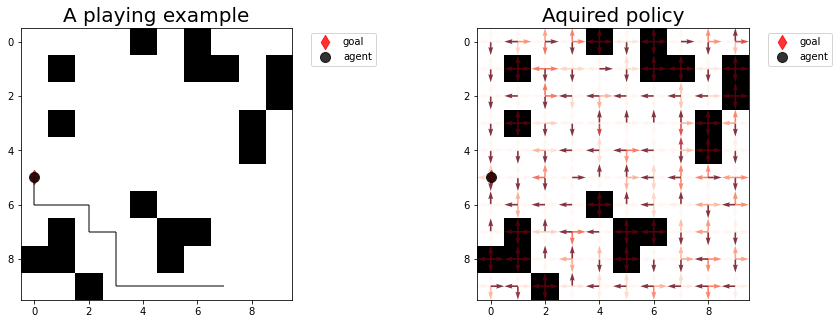

In [84]:
env.reset()

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121); ax1.set_title("A playing example", fontsize=20) 
ax2 = fig.add_subplot(122); ax2.set_title("Aquired policy", fontsize=20) 

env.play(agent, fig=fig, ax=ax1, canvas=True)
env.render(fig=fig, ax=ax2, values_table=agent.policy.H)

Critic が正しく盤面の価値を推定できている様子もわかります：

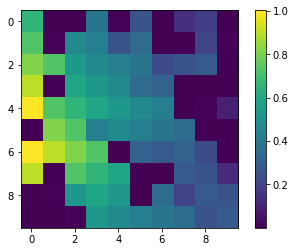

In [85]:
plt.imshow(critic.v.T); plt.colorbar(); plt.show()

#### GANとの関係
同時に２つのモデルを、互いに助け合いながら訓練するのが少し**敵対的生成ネットワーク**に似ている気がしますが、実際様々な側面から類似性が議論されています。